# SMS Spam Classification incorporating feature engineering and a CNN-LSTM hybrid architecture

Denton Tran z5362396 Steven Yang z5358438

Group Name: Upcoming Prompt Engineers

## Introduction

With the growth in the accessibility of mobile phones rising every year, this augmentation has led to the dramatic increase in SMS spam messages over the years. Consequently, this issue of undetected spam messages poses a dire threat towards efficient telecommunication and user privacy. This notebook aims to address this social and technological issue by the development of a SMS spam classification system that leverages feature engineering and a hybrid Convolutional Neural Network-Long Short-Term Memory (CNN-LSTM) architecture. Whilst taking in a multitude of ideas from other classification systems, our contribution lies in bridging the gap between traditional machine learning techniques and cutting-edge deep learning models in  harnessing the strengths of both to improve the accuracy and adaptability of spam detection. Through meticulous preprocessing and feature engineering techniques, we extract meaningful characteristics from SMS data providing the hybrid model with a rich set of inputs for robust classification. The integration of a CNN-LSTM architecture allows the model to capture both local and global dependencies within the text, enhancing its ability to discern subtle patterns indicative of spam.


## Methods

We used a SMS spam dataset uploaded to Kaggle from the UCI Machine Learning Repository.


To download, follow this link https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [113]:
# Read data into a Panda's DataFrame for processing
import pandas as pd
df = pd.read_csv("spam.csv", encoding='latin-1')
df.drop_duplicates()
df.dropna(how="any", inplace=True, axis=1)
df.columns = ['label', 'message']
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### Exploratory Data Analysis

Before we started building our model, a comprehensive exploratory data analysis was necessary to understand the dataset given to us. This analytical exploration involved a meticulous examination of the data’s structure, identifying missing or anomalous data that raises methods or strategies we could use to clean the data. Moreover, assessing the distribution of variables and the necessity of a transformation and uncovering trends or irregularities that may affect the effectiveness of our built model.

In [114]:
# Generates descriptive statistics on each column
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


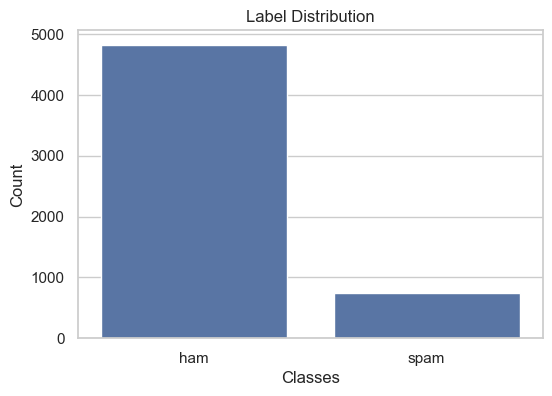

In [115]:
# Observe the distribution of labels
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))

ax = sns.countplot(x = "label", data=df)

ax.set_xlabel("Classes")
ax.set_ylabel("Count")
ax.set_title("Label Distribution")

plt.show()

### Feature Engineering

In this project, we hypothesised that whilst pre-processing techniques in NLP such as stemming, removal of symbols, etc, are crucial in noise reduction and handling sparsity, we can lose a lot of context especially with tasks such as SMS spam detection where these features are intrinsically linked towards spam detection. We took inspiration from Serkan Ballı and Onur Karasoy's paper on the Development of content-based SMS classification application by using Word2Vec-based feature extraction where they delineated about using feature extraction techniques similar to my proposal to capture the structural properties of a message. However, in their approach, they added these features to the dataset as keywords and used this to train their Word2Vec model. In our paradigm, we decided to incorporate these features during training the CNN-LSTM model for a reason we will discuss  below.

### Problem Statement

We test the following hypothesises

- H0 = concatenating features in the CNN-LSTM model does not improve the model’s overall performance
- H1 = concatenating features in the CNN-LSTM model does improve the model’s overall performance

Here, we hypothesised 6 features
* number of characters in a message
* number of words in a message
* proportion of capital letters in a message
* binary variable that encodes whether number/s are contained in a message
* binary variable that encodes whether URL/s are contained in a message

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

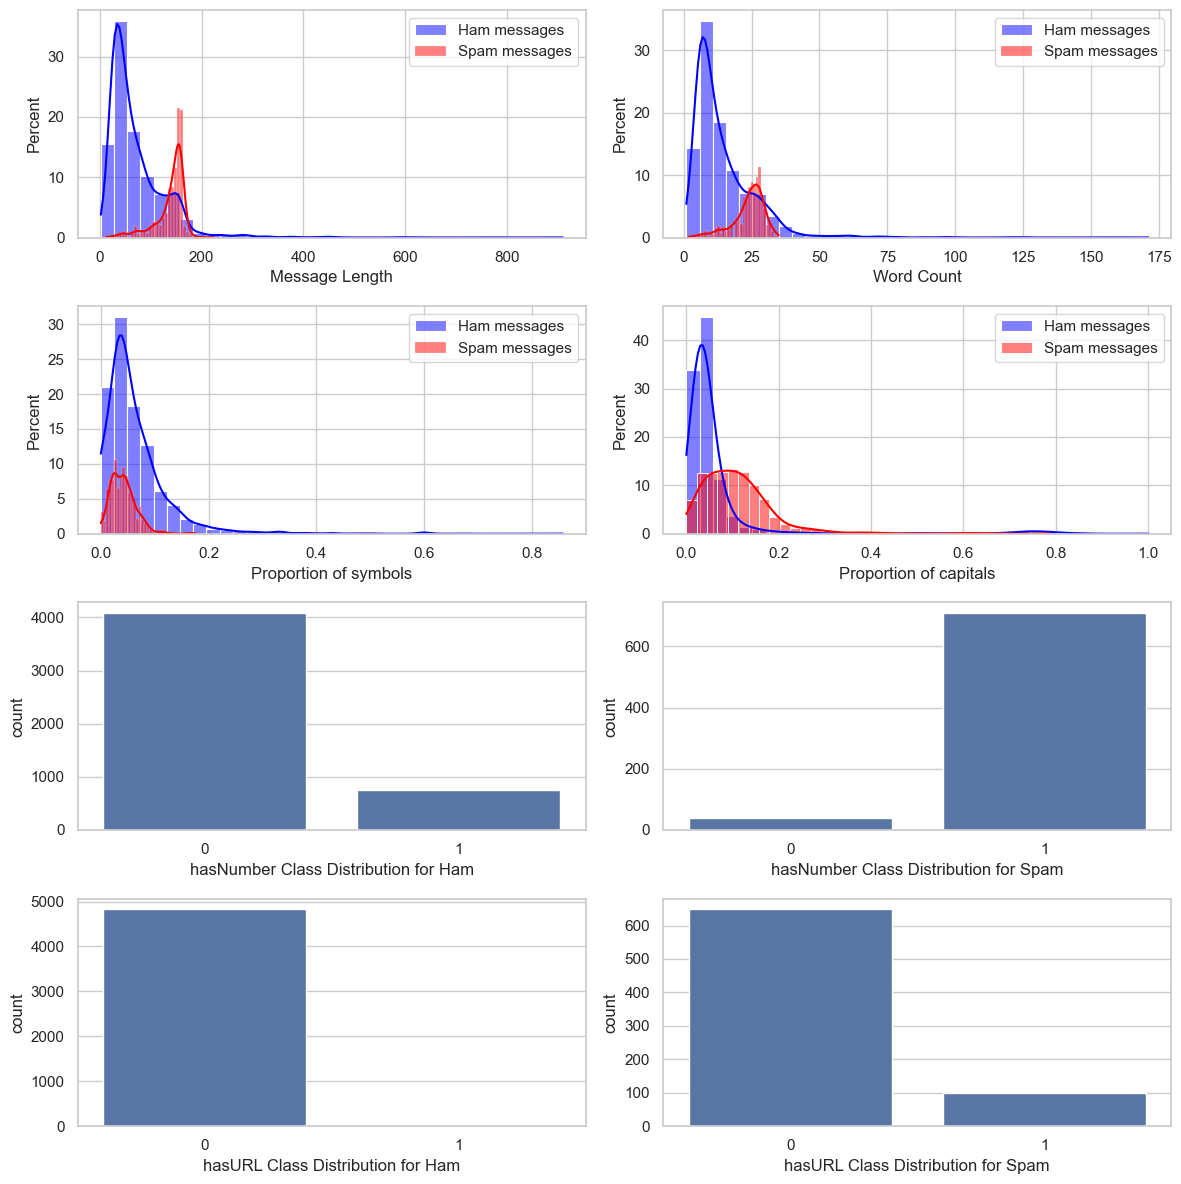

In [116]:
import string
from nltk.corpus import words
from tqdm.notebook import tqdm
import re 


def count_words(text):
    return len(text.split(" "))

def count_symbols(message):
    symbols = set(string.punctuation)
    count = sum(1 for char in message if char in symbols)
    return count / len(message)

def count_capitals(message):
    count = sum(1 for char in message if char.isupper())
    return count / len(message)

def hasNumber(message):
    letters = [letter for letter in message if letter.isdigit()]
    return 0 if len(letters) == 0 else 1

def has_URL(message):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    for token in message.split(" "):
        if url_pattern.match(token):
            return 1
    return 0    


# Label into binary column
df["label"] = df["label"].map({"ham": 0, "spam": 1})

# Create new features 
tqdm.pandas(desc='My bar!')
df["length"] = df["message"].progress_apply(len)

tqdm.pandas(desc='My bar!')
df["word_count"] = df["message"].progress_apply(count_words)

tqdm.pandas(desc='My bar!')
df["symbols"] = df["message"].progress_apply(count_symbols)

tqdm.pandas(desc='My bar!')
df["capitals"] = df["message"].progress_apply(count_capitals)

tqdm.pandas(desc='My bar!')
df['numbers'] = df['message'].progress_apply(hasNumber)

tqdm.pandas(desc='My bar!')
df['hasURL'] = df['message'].progress_apply(has_URL)


# Plot 1: Message Length
plt.figure(figsize=(12, 12))
plt.subplot(4, 2, 1)
ham_data = df[df["label"] == 0]
sns.histplot(ham_data["length"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")
spam_data = df[df["label"] == 1]
sns.histplot(spam_data["length"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")
plt.legend()
plt.xlabel("Message Length")

# Plot 2: Word Count
plt.subplot(4, 2, 2)
ham_data = df[df["label"] == 0]
sns.histplot(ham_data["word_count"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")
spam_data = df[df["label"] == 1]
sns.histplot(spam_data["word_count"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")
plt.legend()
plt.xlabel("Word Count")

# Plot 3: Proportion of Symbols
plt.subplot(4, 2, 3)
ham_data = df[df["label"] == 0]
sns.histplot(ham_data["symbols"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")
spam_data = df[df["label"] == 1]
sns.histplot(spam_data["symbols"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")
plt.legend()
plt.xlabel("Proportion of symbols")

# Plot 4: Proportion of Capitals
plt.subplot(4, 2, 4)
ham_data = df[df["label"] == 0]
sns.histplot(ham_data["capitals"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")
spam_data = df[df["label"] == 1]
sns.histplot(spam_data["capitals"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")
plt.legend()
plt.xlabel("Proportion of capitals")

# Plot 5: Count plot of Ham for hasNumbers
plt.subplot(4, 2, 5)
ham_data = df[df["label"] == 0]
sns.countplot(x="numbers", data=df[df["label"] == 0])
plt.xlabel("hasNumber Class Distribution for Ham")

# Plot 6: Count plot of Spam for hasNumbers
plt.subplot(4, 2, 6)
spam_data = df[df["label"] == 1]
sns.countplot(x="numbers", data=df[df["label"] == 1])
plt.xlabel("hasNumber Class Distribution for Spam")

# Plot 7: Count plot of Ham for hasURL
plt.subplot(4, 2, 7)
ham_data = df[df["label"] == 0]
sns.countplot(x="hasURL", data=df[df["label"] == 0])
plt.xlabel("hasURL Class Distribution for Ham")

# Plot 8: Count plot of Spam for hasURL
plt.subplot(4, 2, 8)
spam_data = df[df["label"] == 1]
sns.countplot(x="hasURL", data=df[df["label"] == 1])
plt.xlabel("hasURL Class Distribution for Spam")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Furthermore, in the paper discussed above, they reviewed a set of related works and Bozan et al. presents his own solution whereby he built a classification system with the help of an expert system. He proposed that features were extracted from the training data and were determined to stay in the training based on a criterion. We took this inspiration but rather than create an expert system, we used visualisations such as histograms and statistical tests such as Kolmogorov-Smirnov (KS) test to pick the most relevant features for our model. Above, we qualitatively observed whether the two distributions for ham and spam messages were different. We chose the Kolmogorov-Smirnov test because it is non-parametric meaning that it doesn't assume a specific probability distribution for the data whilst the data mostly appears to be normally distributed in our case and it is also suitable for continuous or ordinal data.


In [117]:
from scipy.stats import ks_2samp

features = [i for i in df.columns if i not in ["label", "message"]]
for feature in features:
    ks_statistic, p_value = ks_2samp(ham_data[feature], spam_data[feature])
    print(f"Kolmogorov-Smirnov Statistic for {feature}:", ks_statistic)
    print("P-Value:", p_value)
    alpha = 0.05 
    if p_value < alpha:
        print("The distributions are significantly different.")
    else:
        print("The distributions are not significantly different.")
    print("--------------------------------------------")

Kolmogorov-Smirnov Statistic for length: 0.6784415728544576
P-Value: 8.17299035435783e-290
The distributions are significantly different.
--------------------------------------------
Kolmogorov-Smirnov Statistic for word_count: 0.594013220411872
P-Value: 1.6806655583102593e-215
The distributions are significantly different.
--------------------------------------------
Kolmogorov-Smirnov Statistic for symbols: 0.21631201836707797
P-Value: 5.046492269780785e-27
The distributions are significantly different.
--------------------------------------------
Kolmogorov-Smirnov Statistic for capitals: 0.5352696450742521
P-Value: 4.415291113781373e-172
The distributions are significantly different.
--------------------------------------------
Kolmogorov-Smirnov Statistic for numbers: 0.7927652579228832
P-Value: 1.186e-321
The distributions are significantly different.
--------------------------------------------
Kolmogorov-Smirnov Statistic for hasURL: 0.132115612709907
P-Value: 2.634276312017415

### Pre-processing

In the paper discussed above, we similarly borrowed their message preparation where they remove digits, punctuations, and symbols. Then, all characters are translated to lowercase and URLs are removed. Additionally, we decided to also stem words in the message via the Porter Stemming algorithm to improve text matching and then removing all stopwords to reduce noise and reduce the dimensionality of the data and vocabulary and finally removing all words that have a length of less than 2 as they like stopwords add noise and are uninformative enough to discard. We also do further feature extraction during/after this step where we introduced variables that capture richer context such as frequency of misspelt words, sentiment labels which are theoretically improved after cleaning. We check the frequency of misspelt words during this step because stopwords contribute to the correctness of a message.

In [118]:
# Punctuation removal
def process_text(message):
    message = "".join([char for char in message if char not in string.punctuation]).lower()
    return message
df["message"] = df["message"].apply(process_text)
df

,label,message,length,word_count,symbols,capitals,numbers,hasURL
0,0,go until jurong point crazy available only in ...,111,20,0.081081,0.027027,0,0
1,0,ok lar joking wif u oni,29,6,0.206897,0.068966,0,0
2,1,free entry in 2 a wkly comp to win fa cup fina...,155,28,0.038710,0.064516,1,0
3,0,u dun say so early hor u c already then say,49,11,0.122449,0.040816,0,0
4,0,nah i dont think he goes to usf he lives aroun...,61,13,0.032787,0.032787,0,0
...,...,...,...,...,...,...,...,...
5567,1,this is the 2nd time we have tried 2 contact u...,161,30,0.049689,0.055901,1,0
5568,0,will ì b going to esplanade fr home,37,8,0.054054,0.054054,0,0
5569,0,pity was in mood for that soany other suggest...,57,10,0.122807,0.035088,0,0
5570,0,the guy did some bitching but i acted like id ...,125,26,0.008000,0.016000,0,0


In [152]:
# Remove all non-letters
def replace_non_letters(message):
    lowercase_alphabet = string.ascii_lowercase + " "
    processed_words = [letter for letter in str(message) if letter in lowercase_alphabet]
    return ''.join(processed_words)

tqdm.pandas(desc='My bar!')
df['message'] = df['message'].progress_apply(replace_non_letters)
df

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

,label,message,length,word_count,symbols,capitals,numbers,hasURL,misspelt,sentiment_label,tokens
0,0,go jurong point crazi avail bugi great world l...,0.517399,0.384646,0.363322,-0.360707,0,0,-1.018602,1,"[go, jurong, point, crazi, avail, bugi, great,..."
1,0,ok lar joke wif oni,-0.856470,-0.841118,2.511001,0.023752,0,0,-0.065975,1,"[ok, lar, joke, wif, oni]"
2,1,free entri wkli comp win fa cup final tkt st m...,1.254596,1.085083,-0.359960,-0.017036,1,0,0.994340,1,"[free, entri, wkli, comp, win, fa, cup, final,..."
3,0,dun say earli hor alreadi say,-0.521380,-0.403345,1.069475,-0.234298,0,0,-0.065975,1,"[dun, say, earli, hor, alreadi, say]"
4,0,nah think goe usf live around though,-0.320326,-0.228236,-0.461063,-0.307905,0,0,0.124550,1,"[nah, think, goe, usf, live, around, though]"
...,...,...,...,...,...,...,...,...,...,...,...
5567,1,nd time tri contact pound prize claim easi ca...,1.355123,1.260193,-0.172535,-0.096016,1,0,0.335131,1,"[nd, time, tri, contact, å£, pound, prize, cla..."
5568,0,go esplanad fr home,-0.722434,-0.666009,-0.098031,-0.112944,0,0,0.696126,0,"[go, esplanad, fr, home]"
5569,0,piti mood soani suggest,-0.387344,-0.490900,1.075587,-0.286813,0,0,1.153387,1,"[piti, mood, soani, suggest]"
5570,0,guy bitch act like id interest buy someth els ...,0.751962,0.909974,-0.884177,-0.461795,0,0,-1.263563,1,"[guy, bitch, act, like, id, interest, buy, som..."


In [120]:
# Remove all urls
import re 
def replace_urls(message):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    replaced_tokens = [token for token in message.split(" ") if not url_pattern.match(token)]
    return ' '.join(replaced_tokens)

tqdm.pandas(desc='My bar!')
df['message'] = df['message'].progress_apply(replace_urls)
df

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

,label,message,length,word_count,symbols,capitals,numbers,hasURL
0,0,go until jurong point crazy available only in ...,111,20,0.081081,0.027027,0,0
1,0,ok lar joking wif u oni,29,6,0.206897,0.068966,0,0
2,1,free entry in a wkly comp to win fa cup final...,155,28,0.038710,0.064516,1,0
3,0,u dun say so early hor u c already then say,49,11,0.122449,0.040816,0,0
4,0,nah i dont think he goes to usf he lives aroun...,61,13,0.032787,0.032787,0,0
...,...,...,...,...,...,...,...,...
5567,1,this is the nd time we have tried contact u u...,161,30,0.049689,0.055901,1,0
5568,0,will ì b going to esplanade fr home,37,8,0.054054,0.054054,0,0
5569,0,pity was in mood for that soany other suggest...,57,10,0.122807,0.035088,0,0
5570,0,the guy did some bitching but i acted like id ...,125,26,0.008000,0.016000,0,0


In [121]:
# Reducing the size of the vocabulary by stemming
from nltk.stem.porter import PorterStemmer

def stemming(text):
    port_stem = PorterStemmer()
    text = [port_stem.stem(word) for word in text.split(" ") if word not in stopwords.words('english')]
    return " ".join(text)

tqdm.pandas(desc='My bar!')
df["message"] = df["message"].progress_apply(stemming)
df

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

,label,message,length,word_count,symbols,capitals,numbers,hasURL
0,0,go jurong point crazi avail bugi n great world...,111,20,0.081081,0.027027,0,0
1,0,ok lar joke wif u oni,29,6,0.206897,0.068966,0,0
2,1,free entri wkli comp win fa cup final tkt st ...,155,28,0.038710,0.064516,1,0
3,0,u dun say earli hor u c alreadi say,49,11,0.122449,0.040816,0,0
4,0,nah dont think goe usf live around though,61,13,0.032787,0.032787,0,0
...,...,...,...,...,...,...,...,...
5567,1,nd time tri contact u u å£ pound prize claim...,161,30,0.049689,0.055901,1,0
5568,0,ì b go esplanad fr home,37,8,0.054054,0.054054,0,0
5569,0,piti mood soani suggest,57,10,0.122807,0.035088,0,0
5570,0,guy bitch act like id interest buy someth els ...,125,26,0.008000,0.016000,0,0


Here, we observe that the frequency of misspelt words is distributed differently across the different classes through the histogram and the test statistics. Thus, we will include this as a feature in our model.

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

Kolmogorov-Smirnov Statistic: 0.4574603769135263
P-Value: 1.692515349820237e-123
The distributions are significantly different.


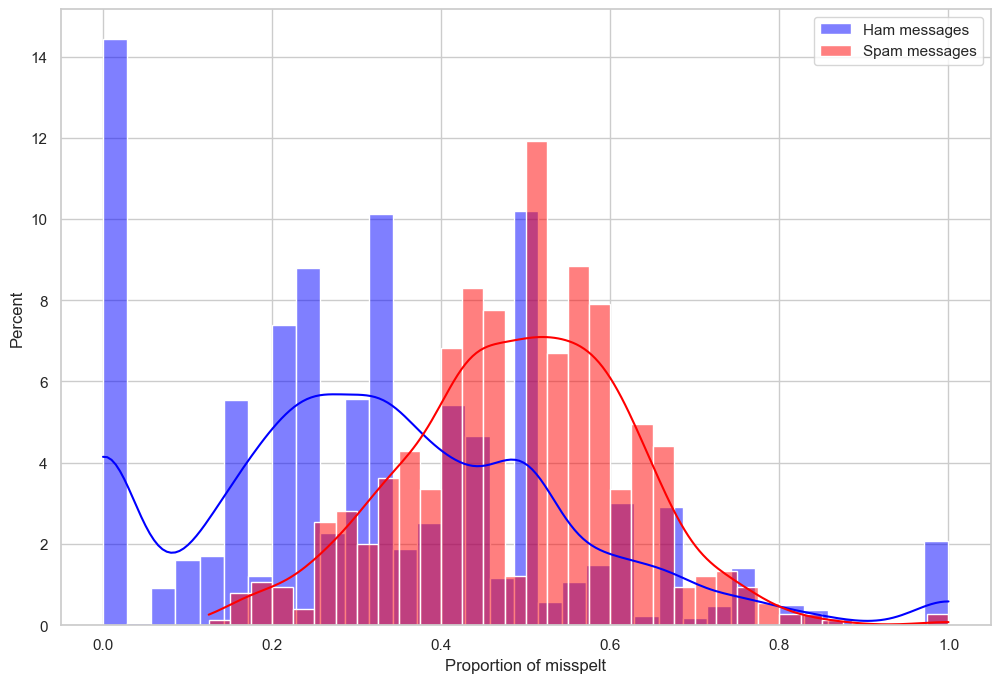

In [122]:
# Counting the frequency of misspelt words
def freq_incorrect(text):
    strings = text.split(" ")
    english_vocab = set(w.lower() for w in words.words())
    misspelled = len([word for word in strings if word not in english_vocab])
    return misspelled / len(strings)

tqdm.pandas(desc='My bar!')
df["misspelt"] = df["message"].progress_apply(freq_incorrect)

ham_data = df[df["label"] == 0]
spam_data = df[df["label"] == 1]

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(ham_data["misspelt"], spam_data["misspelt"])

# Print the results
print("Kolmogorov-Smirnov Statistic:", ks_statistic)
print("P-Value:", p_value)

# Determine statistical significance
alpha = 0.05
if p_value < alpha:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

plt.figure(figsize=(12, 8))

# Filter data for label=0 (Ham messages)
sns.histplot(ham_data["misspelt"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")

# Filter data for label=1 (Spam messages)
sns.histplot(spam_data["misspelt"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")

plt.legend()
plt.xlabel("Proportion of misspelt")
plt.show()

In [123]:
# Remove stopwords
from nltk.corpus import stopwords
def remove_stopwords(message):
    STOPWORDS  = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    return ' '.join([word for word in message.split() if word not in STOPWORDS])

tqdm.pandas(desc='My bar!')
df["message"] = df["message"].progress_apply(remove_stopwords)

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

In [130]:
# Remove all words that are less than 2
def length_restrict(message):
    return ' '.join(i for i in message.split() if len(i) > 1)

tqdm.pandas(desc='My bar!')
df["message"] = df["message"].progress_apply(length_restrict)
df

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

,label,message,length,word_count,symbols,capitals,numbers,hasURL,misspelt,sentiment_label,tokens
0,0,go jurong point crazi avail bugi great world l...,111,20,0.081081,0.027027,0,0,0.125000,1,"[go, jurong, point, crazi, avail, bugi, great,..."
1,0,ok lar joke wif oni,29,6,0.206897,0.068966,0,0,0.333333,1,"[ok, lar, joke, wif, oni]"
2,1,free entri wkli comp win fa cup final tkt st m...,155,28,0.038710,0.064516,1,0,0.565217,1,"[free, entri, wkli, comp, win, fa, cup, final,..."
3,0,dun say earli hor alreadi say,49,11,0.122449,0.040816,0,0,0.333333,1,"[dun, say, earli, hor, alreadi, say]"
4,0,nah think goe usf live around though,61,13,0.032787,0.032787,0,0,0.375000,1,"[nah, think, goe, usf, live, around, though]"
...,...,...,...,...,...,...,...,...,...,...,...
5567,1,nd time tri contact å£ pound prize claim easi ...,161,30,0.049689,0.055901,1,0,0.421053,1,"[nd, time, tri, contact, å£, pound, prize, cla..."
5568,0,go esplanad fr home,37,8,0.054054,0.054054,0,0,0.500000,0,"[go, esplanad, fr, home]"
5569,0,piti mood soani suggest,57,10,0.122807,0.035088,0,0,0.600000,1,"[piti, mood, soani, suggest]"
5570,0,guy bitch act like id interest buy someth els ...,125,26,0.008000,0.016000,0,0,0.071429,1,"[guy, bitch, act, like, id, interest, buy, som..."


For this sentimentl label, we will be using a pretrained model i.e., BERT to predict labels for each message to capture the emotional polarity of each message. Here, we also observe that the sentiment label is distributed differently across the different classes through the histogram and the test statistics. Thus, we will include this as a feature in our model.

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

Kolmogorov-Smirnov Statistic: 0.26856108371309073
P-Value: 1.2856369929769762e-41
The distributions are significantly different.


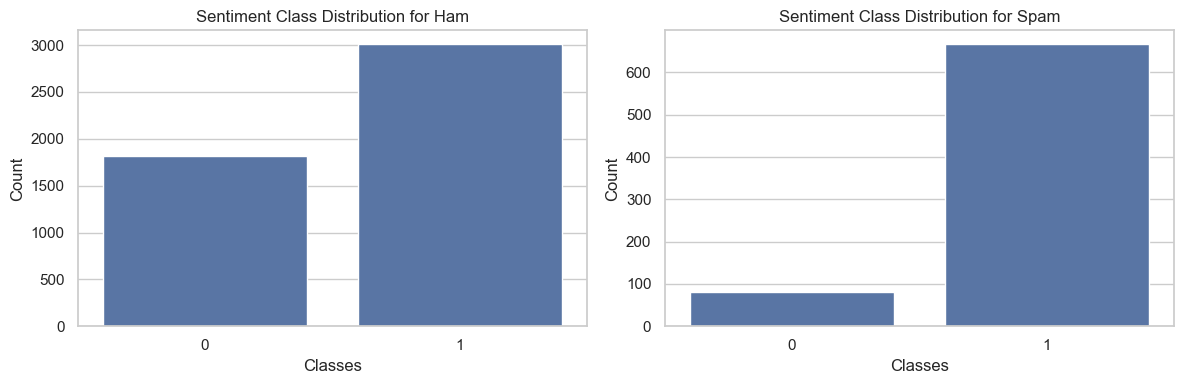

In [126]:
# Adding a sentiment feature
from transformers import pipeline
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)
def sentiment_label(text, sentiment_pipeline):
    label = sentiment_pipeline(text)[0]["label"]
    if label == "POSITIVE":
        return 0
    else:
        return 1

tqdm.pandas(desc='My bar!')
df["sentiment_label"] = df["message"].progress_apply(lambda x: sentiment_label(x, sentiment_pipeline=sentiment_pipeline))

ham_data = df[df["label"] == 0]
spam_data = df[df["label"] == 1]

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(ham_data["sentiment_label"], spam_data["sentiment_label"])

# Print the results
print("Kolmogorov-Smirnov Statistic:", ks_statistic)
print("P-Value:", p_value)

# Determine statistical significance
alpha = 0.05
if p_value < alpha:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")


# Set the style
sns.set(style="whitegrid")

# Create a 1x2 subplot layout
plt.figure(figsize=(12, 4))

# Plot for Ham
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x="sentiment_label", data=df[df["label"] == 0])
ax1.set_xlabel("Classes")
ax1.set_ylabel("Count")
ax1.set_title("Sentiment Class Distribution for Ham")

# Plot for Spam
plt.subplot(1, 2, 2)
ax2 = sns.countplot(x="sentiment_label", data=df[df["label"] == 1])
ax2.set_xlabel("Classes")
ax2.set_ylabel("Count")
ax2.set_title("Sentiment Class Distribution for Spam")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


### Results of string pre-processing

Here we have a dictionary that stores word frequencies in descending order

In [154]:
from itertools import chain
from collections import Counter
from nltk.tokenize import word_tokenize

df['tokens'] = df['message'].apply(word_tokenize)
vocab_list = list(chain(*df["tokens"].tolist()))
counter = Counter(vocab_list)
counter

Counter({'call': 656,
         'go': 453,
         'get': 451,
         'come': 297,
         'free': 278,
         'ok': 277,
         'ltgt': 276,
         'know': 270,
         'like': 255,
         'day': 255,
         'got': 251,
         'love': 244,
         'want': 243,
         'ill': 243,
         'time': 239,
         'good': 235,
         'text': 225,
         'send': 204,
         'need': 186,
         'one': 180,
         'txt': 177,
         'see': 171,
         'today': 169,
         'think': 166,
         'home': 162,
         'stop': 161,
         'repli': 160,
         'take': 160,
         'lor': 160,
         'tell': 156,
         'sorri': 156,
         'still': 153,
         'back': 152,
         'mobil': 151,
         'make': 147,
         'phone': 142,
         'say': 138,
         'pleas': 136,
         'new': 136,
         'week': 135,
         'work': 134,
         'well': 134,
         'later': 134,
         'da': 133,
         'hi': 133,
         'ask': 132

Moreover, we have a graphical visualisation of word frequencies in the data. Overall, it shows us that the data is cleaned as redefined. We decided to build our own Word2Vec model to train the text messages since there are several strings such as liao or leh that are slang and are not typical english vocabulary to capture its meaning in the context instead of applying a one-hot encoding for words that are not found in pre-trained sets of vectors.

<function matplotlib.pyplot.show(close=None, block=None)>

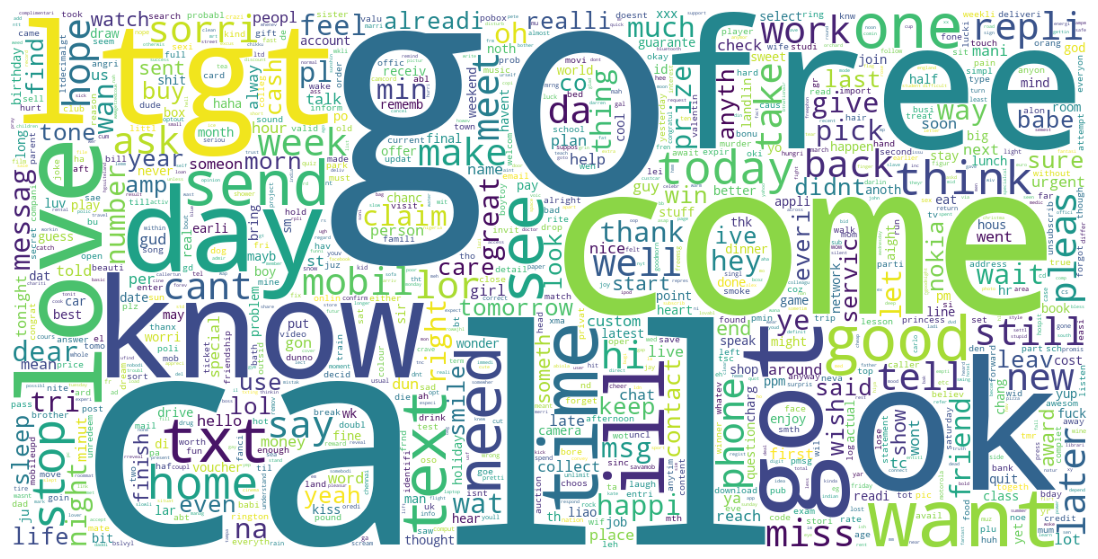

In [155]:
from wordcloud import WordCloud

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "#410F01", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)
wc.generate(' '.join(vocab_list))

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show

### Splitting the data

Finally after feature selection, we have the following features
* number of characters in a message
* number of words in a message
* proportion of capital letters in a message
* binary variable that encodes whether number/s are contained in a message
* binary variable that encodes whether URL/s are contained in a message
* proportion of incorrectly spelt strings
* sentiment label

Now that we have extracted all our features. We standardise them to ensure features are equally treated.

In [156]:
from sklearn.preprocessing import StandardScaler

columns_to_standardize = [i for i in df.columns if i not in ["label", "message", "sentiment_label", "tokens", "numbers", "numbers", "hasURL"]]
scaler = StandardScaler()

# Fit and transform the selected columns
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
df.to_csv('cleaned_sms.csv', index=False)
df

,label,message,length,word_count,symbols,capitals,numbers,hasURL,misspelt,sentiment_label,tokens
0,0,go jurong point crazi avail bugi great world l...,0.517399,0.384646,0.363322,-0.360707,0,0,-1.018602,1,"[go, jurong, point, crazi, avail, bugi, great,..."
1,0,ok lar joke wif oni,-0.856470,-0.841118,2.511001,0.023752,0,0,-0.065975,1,"[ok, lar, joke, wif, oni]"
2,1,free entri wkli comp win fa cup final tkt st m...,1.254596,1.085083,-0.359960,-0.017036,1,0,0.994340,1,"[free, entri, wkli, comp, win, fa, cup, final,..."
3,0,dun say earli hor alreadi say,-0.521380,-0.403345,1.069475,-0.234298,0,0,-0.065975,1,"[dun, say, earli, hor, alreadi, say]"
4,0,nah think goe usf live around though,-0.320326,-0.228236,-0.461063,-0.307905,0,0,0.124550,1,"[nah, think, goe, usf, live, around, though]"
...,...,...,...,...,...,...,...,...,...,...,...
5567,1,nd time tri contact pound prize claim easi ca...,1.355123,1.260193,-0.172535,-0.096016,1,0,0.335131,1,"[nd, time, tri, contact, pound, prize, claim, ..."
5568,0,go esplanad fr home,-0.722434,-0.666009,-0.098031,-0.112944,0,0,0.696126,0,"[go, esplanad, fr, home]"
5569,0,piti mood soani suggest,-0.387344,-0.490900,1.075587,-0.286813,0,0,1.153387,1,"[piti, mood, soani, suggest]"
5570,0,guy bitch act like id interest buy someth els ...,0.751962,0.909974,-0.884177,-0.461795,0,0,-1.263563,1,"[guy, bitch, act, like, id, interest, buy, som..."


Splitting the data into train and validation set

In [2]:
from sklearn.model_selection import train_test_split

X = df[[i for i in df.columns if i != "label"]]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
X_train

,message,length,word_count,symbols,capitals,numbers,hasURL,misspelt,sentiment_label,tokens
1642,sleep nt feel well,-0.940242,-1.016228,-1.020737,-0.226502,0,0,-0.447026,0,"[sleep, nt, feel, well]"
2899,come aftr ltdecimalgt clean hous,-0.420853,-0.490900,0.841452,0.724945,0,0,1.458228,1,"[come, aftr, ltdecimalgt, clean, hous]"
480,almost see sec,-0.873224,-0.753564,-0.411092,-0.281069,0,0,-1.590178,1,"[almost, see, sec]"
3485,yeah probabl earlier,-0.806206,-0.928673,-0.487298,-0.321994,0,0,-0.065975,0,"[yeah, probabl, earlier]"
157,hello love get interview today happi good boy ...,1.288105,1.522857,-0.150925,-0.199740,0,0,-0.447026,0,"[hello, love, get, interview, today, happi, go..."
...,...,...,...,...,...,...,...,...,...,...
905,hey charl sorri late repli,-0.521380,-0.578455,-0.324000,-0.421384,0,0,0.696126,0,"[hey, charl, sorri, late, repli]"
5192,oh oh den muz chang plan liao go back yan jiu,-0.186290,-0.140681,1.205793,-0.209895,0,0,-0.343103,1,"[oh, oh, den, muz, chang, plan, liao, go, back..."
3980,huh cant thk oredi mani page,-0.420853,-0.228236,-0.710372,-0.441793,0,0,-0.065975,1,"[huh, cant, thk, oredi, mani, page]"
235,print oh ltgt come upstair,-0.504625,-0.403345,1.027671,-0.241781,0,0,0.369512,1,"[print, oh, ltgt, come, upstair]"


### Train a Word2Vec network to obtain word vectors

We built a Word2Vec model using the vocabulary in the training set using skip-gram. 

In [3]:
import gensim.models.keyedvectors as word2vec
from gensim import models
X_train_corpus = X_train["tokens"].tolist()
X_test_corpus = X_test["tokens"].tolist()
w2v_model = models.Word2Vec(vector_size=300, window=3, min_count=5, workers=8)
w2v_model.build_vocab(X_train_corpus)
words = w2v_model.wv
vocab_size = len(words)
print("Vocab size", vocab_size)
w2v_model.train(X_train_corpus,total_examples=len(X_train_corpus),epochs=32)

Vocab size 1290


(832789, 1182112)

We applied text tokenization and sequence padding using Keras


In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train_corpus)

tokenized_train = tokenizer.texts_to_sequences(X_train_corpus)
tokenized_test = tokenizer.texts_to_sequences(X_test_corpus)

max_len = X_train["tokens"].apply(lambda x: len(x)).max()
train_x = sequence.pad_sequences(tokenized_train, maxlen = max_len)
test_x = sequence.pad_sequences(tokenized_test, maxlen = max_len)
train_x.shape

(4457, 79)

Next, we formed our embedding layer. (Note: Some words may not be found because we set min_count = 5 for w2v_model)

In [5]:
# Build Embedding Layer
import numpy as np
from keras.layers import Activation, Dense, Dropout, Embedding

vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 300))
print(embedding_matrix)
for word, i in tqdm(tokenizer.word_index.items()):
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


  0%|          | 0/6259 [00:00<?, ?it/s]

(6260, 300)


Since we observed previously that there is a class imbalance, we use class weights to balance the classes to preserve integrity of the true results with less bias towards either side

In [6]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

### Building our CNN-LSTM model

In our project, we decide to utilise a hybrid CNN-LSTM model that was shown to yield successful results in Ghourabi A, Mahmood MA, Alzubi QM.'s paper titled "A Hybrid CNN-LSTM Model for SMS Spam Detection in Arabic and English Messages". They showed how this hybrid nature was able to beat conventional machine learning techniques or purely CNN/LSTM architecture in most accuracy metrics. In their architecture, the first layer consists of a word embedding, followed by a convolutional layer, a max pooling layer, their LSTM layer, a dense layer followed finally by an output layer. 

We adapt their proposed model in our neural network architecture shown sequentially as the following:
1. Word Embedding
2. Convolution 1D
3. Batch Normalisation
4. Max Pooling
5. LSTM concatenated with features
6. Dense Layer
7. Output Layer

* Convolutional Layer\
In the paper, we followed the idea that the convolutional layer was applied for the purpose of extracting relevant features through the convolution operations across the word vectors
* Batch Normalisation\
Unlike Ghourabi A, Mahmood MA, Alzubi QM.'s approach in their paper, we applied a batch normalisation on each mini-batch to improve training speed and convergence and to  stabilise and normalise the gradient flow during backpropagation which can lead to better gradient descent optimization and more stable learning. This layer is then applied with a relu activtation function to introduce sparsity and further mitigates vanishing/exploding gradients
* Max Pooling\
Similar to their reasoning for applying max pooling, this layer was added to prevent overfitting due to noisy text and subset the most important information captured in the previous layer
* LSTM concatenated with features\
Ghourabi A, Mahmood MA, Alzubi QM. delineate their reasoning for incorporating a hybrid architecture was because whilst CNN is advantageous in extracting the most relevant features from text input, it is unable to correlate the information sequentially. The proposed LSTM architecture is a recurrent neural network architecture is able to learn long term dependencies that is crucial in understanding text data. We concatenate the features on top of the hidden nodes in that layer rather than learn them in the layer because the input features do not depend on each other sequentially and is counter-productive if features were used this way. Rather, we combine all information including features in the fully connected/dense layer.
* Dense Layer\
As stated in the previous dotpoint, this dense layer combines information from the the LSTM layer with the input features into a higher dimensional space to learn non-linear relationships whereby each neuron in the dense layer learns a specific feature representation. 
* Output Layer\
The output layer is a dense layer with 1 neuron whereby the neuron's domain lies between 0 to 1 via a sigmoid activation function.

Unfortunately, we could not find a solution to conduct hyperparameter search for a multichannel neural network in the KerasClassifier package and thus, hyperparameter tuning done manually.

In [7]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, concatenate, Flatten, BatchNormalization

# Input for text data
text_input = Input(shape=(max_len,), name='text_input')
embedded_sequences = embedding_layer(text_input)


conv1D_layer = Conv1D(filters=64, kernel_size=3, padding='same')(embedded_sequences)
batch_norm_layer = BatchNormalization()(conv1D_layer)
activation_layer = Activation('relu')(batch_norm_layer)
maxpooling_layer = MaxPooling1D(pool_size=2)(activation_layer)
lstm_layer = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(maxpooling_layer)

# Input for additional features
additional_features = [i for i in X_train.columns if i not in ["message", "tokens"]]
num_features = len(additional_features)
x_train_features = X_train[additional_features]
feature_input = Input(shape=(num_features,), name='feature_input')

# Concatenate the LSTM output and feature input
merged_layer = concatenate([lstm_layer, feature_input])

# Dense layers for further processing
dense_layer1 = Dense(64, activation='relu')(merged_layer)
dropout_layer = Dropout(0.5)(dense_layer1)

# Output layer
output_layer = Dense(1, activation='sigmoid', name='output')(dropout_layer)

# Create the model
model = Model(inputs=[text_input, feature_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 79)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 79, 300)              1878000   ['text_input[0][0]']          
                                                                                                  
 conv1d (Conv1D)             (None, 79, 64)               57664     ['embedding[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 79, 64)               256       ['conv1d[0][0]']              
 Normalization)                                                                               

We test our hypothesis whether our multi-channel model is more effective in sms spam detection than the proposed model by Ghourabi A, Mahmood MA, Alzubi QM.

As stated their model's architecture is the following:
1. Word Embedding
2. Convolution 1D
3. Max Pooling
4. LSTM
5. Dense Layer
6. Output Layer

In [8]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, concatenate, Flatten, BatchNormalization

# Input for text data
text_input = Input(shape=(max_len,), name='text_input')
embedded_sequences = embedding_layer(text_input)


conv1D_layer = Conv1D(filters=64, kernel_size=3, padding='same')(embedded_sequences)
batch_norm_layer = BatchNormalization()(conv1D_layer)
activation_layer = Activation('relu')(batch_norm_layer)
maxpooling_layer = MaxPooling1D(pool_size=2)(activation_layer)
lstm_layer = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(maxpooling_layer)

# Dense layers for further processing
dense_layer1 = Dense(64, activation='relu')(lstm_layer)
dropout_layer = Dropout(0.5)(dense_layer1)

# Output layer
output_layer = Dense(1, activation='sigmoid', name='output')(dropout_layer)

# Create the model
alt_model = Model(inputs=text_input, outputs=output_layer)

# Compile the model
alt_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
alt_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_input (InputLayer)     [(None, 79)]              0         
                                                                 
 embedding (Embedding)       (None, 79, 300)           1878000   
                                                                 
 conv1d_1 (Conv1D)           (None, 79, 64)            57664     
                                                                 
 batch_normalization_1 (Bat  (None, 79, 64)            256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 79, 64)            0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 39, 64)            0         
 g1D)                                                      

In [9]:
%%time
# Training the our multi-channel model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
import pickle

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]
try:
    model = load_model('model.h5')
    with open('history_model.pkl', 'rb') as history_file:
        history = pickle.load(history_file)
except:
    history = model.fit([train_x, x_train_features], y_train,
                    batch_size=32,
                    epochs=16,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks,
                    class_weight=class_weight_dict)
    model.save('model.h5')
    with open('history_model.pkl', 'wb') as history_file:
        pickle.dump(history.history, history_file)

c:\Users\dtren\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/16
126/126 [==============================] - 14s 60ms/step - loss: 0.2020 - accuracy: 0.9322 - val_loss: 0.1430 - val_accuracy: 0.9664 - lr: 0.0010
Epoch 2/16
126/126 [==============================] - 7s 53ms/step - loss: 0.1363 - accuracy: 0.9599 - val_loss: 0.1201 - val_accuracy: 0.9686 - lr: 0.0010
Epoch 3/16
126/126 [==============================] - 6s 51ms/step - loss: 0.1207 - accuracy: 0.9626 - val_loss: 0.0875 - val_accuracy: 0.9686 - lr: 0.0010
Epoch 4/16
126/126 [==============================] - 8s 64ms/step - loss: 0.1074 - accuracy: 0.9698 - val_loss: 0.1394 - val_accuracy: 0.9507 - lr: 0.0010
Epoch 5/16
126/126 [==============================] - 7s 54ms/step - loss: 0.0963 - accuracy: 0.9708 - val_loss: 0.1193 - val_accuracy: 0.9641 - lr: 0.0010
Epoch 6/16
126/126 [==============================] - 6s 51ms/step - loss: 0.0842 - accuracy: 0.9753 - val_loss: 0.0831 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 7/16
126/126 [==============================] - 6s 48ms/s

c:\Users\dtren\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
%%time
# Training their proposed model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
import pickle

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]
try:
    alt_model = load_model('alt_model.h5')
    with open('history_alt_model.pkl', 'rb') as history_file:
        alt_history = pickle.load(history_file)
except:
    alt_history = alt_model.fit(train_x, y_train,
                    batch_size=32,
                    epochs=16,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks,
                    class_weight=class_weight_dict)
    alt_model.save('alt_model.h5')
    with open('history_alt_model.pkl', 'wb') as history_file:
        pickle.dump(alt_history.history, history_file)

Epoch 1/16


c:\Users\dtren\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


126/126 [==============================] - 9s 36ms/step - loss: 0.2397 - accuracy: 0.9242 - val_loss: 0.2045 - val_accuracy: 0.9484 - lr: 0.0010
Epoch 2/16
126/126 [==============================] - 6s 49ms/step - loss: 0.1458 - accuracy: 0.9549 - val_loss: 0.1297 - val_accuracy: 0.9552 - lr: 0.0010
Epoch 3/16
126/126 [==============================] - 7s 57ms/step - loss: 0.1315 - accuracy: 0.9624 - val_loss: 0.1293 - val_accuracy: 0.9507 - lr: 0.0010
Epoch 4/16
126/126 [==============================] - 6s 46ms/step - loss: 0.1243 - accuracy: 0.9658 - val_loss: 0.1257 - val_accuracy: 0.9529 - lr: 0.0010
Epoch 5/16
126/126 [==============================] - 6s 46ms/step - loss: 0.1165 - accuracy: 0.9683 - val_loss: 0.1485 - val_accuracy: 0.9484 - lr: 0.0010
Epoch 6/16
126/126 [==============================] - 7s 54ms/step - loss: 0.1057 - accuracy: 0.9721 - val_loss: 0.0939 - val_accuracy: 0.9686 - lr: 0.0010
Epoch 7/16
126/126 [==============================] - 6s 51ms/step - loss: 

### Model Evaluation

We tested each model using the test data. In the first cell, we observe a general observation of each model's accuracy and loss. Next, we observed the training history to do performance monitoring, detecting overfitting/underfitting and understanding learning dynamics. Afterwards, we obtain a set of accuracy metrics we use to compare each model by such as precision, f1-score, support and recall. Finally, we have a visualisation of the ROC curve and confusion for each model. The ROC curve can help to us to visualise the trade off between sensitivity and specificity while the confusion matrix helps to break down predictions into true positives, true negatives, false positives, and false negatives.

Accuracy and loss for each model
* We observe that our model slightly does better with an accuracy of 0.9901 and a loss of 0.0447 whilst the alternate model only offered an accuracy of 0.9812 and loss of 0.0706 

In [174]:
%%time
print("CNN-LSTM with features")
X_test_features = X_test[additional_features]
score = model.evaluate([test_x, X_test_features], y_test, batch_size=32)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])
print("\n--------------------------------------------\n")

print("CNN-LSTM without features")
X_test_features = X_test[additional_features]
score = alt_model.evaluate(test_x, y_test, batch_size=32)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

CNN-LSTM with features
35/35 [==============================] - 0s 12ms/step - loss: 0.0447 - accuracy: 0.9901

ACCURACY: 0.9901345372200012
LOSS: 0.04472406208515167

--------------------------------------------

CNN-LSTM without features
35/35 [==============================] - 0s 13ms/step - loss: 0.0706 - accuracy: 0.9812

ACCURACY: 0.9811659455299377
LOSS: 0.07060949504375458
CPU times: total: 3.69 s
Wall time: 1.36 s


Training history for each model
* We observe that our model trains alot better with a consistent growth in accuracy and reduction in loss in training and validation whereas the alternate model has a spiky and stagnant across epoches for validation accuracy
* This sporadic behaviour in the single channel network could be from overfitting or varying predictive capabilities.

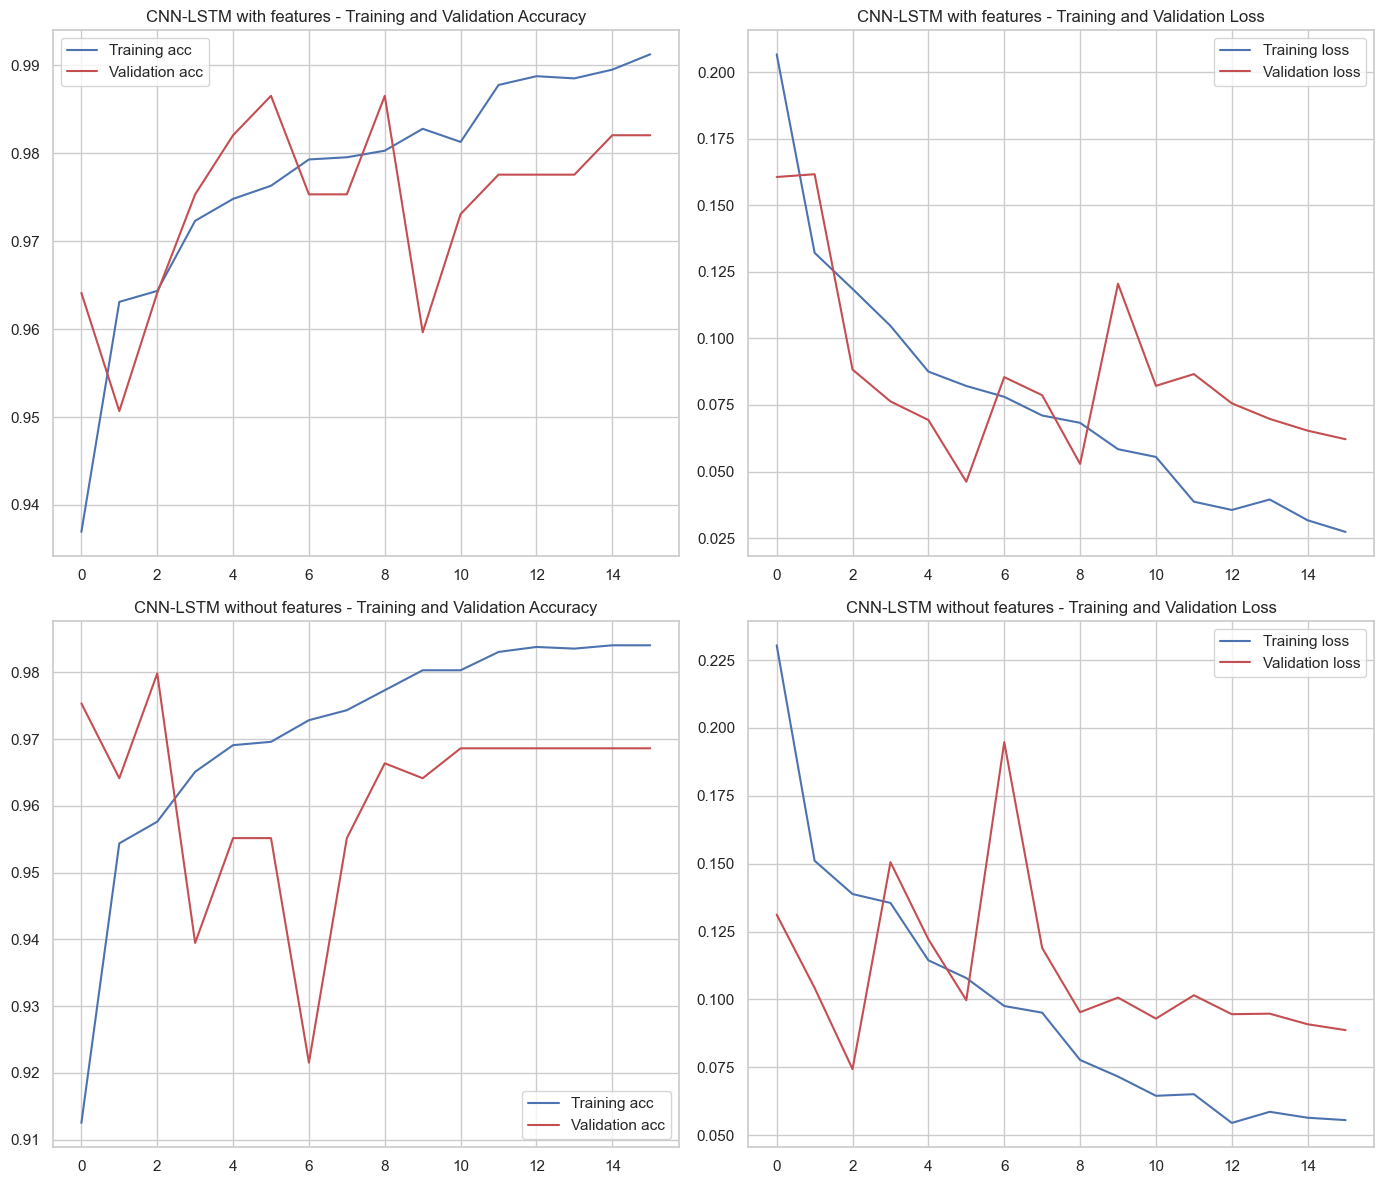

In [175]:
# Plot for the first model
plt.figure(figsize=(14, 12))

# Training and Validation Accuracy
plt.subplot(2, 2, 1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('CNN-LSTM with features - Training and Validation Accuracy')
plt.legend()

# Training and Validation Loss
plt.subplot(2, 2, 2)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('CNN-LSTM with features - Training and Validation Loss')
plt.legend()

# Training and Validation Accuracy
plt.subplot(2, 2, 3)
acc = alt_history.history['accuracy']
val_acc = alt_history.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('CNN-LSTM without features - Training and Validation Accuracy')
plt.legend()

# Training and Validation Loss
plt.subplot(2, 2, 4)
loss = alt_history.history['loss']
val_loss = alt_history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('CNN-LSTM without features - Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


Accuracy metrics for each model
* Our proposed model does better in precision, recall and f1-score across weighted averages

In [176]:
from sklearn.metrics import classification_report

print("CNN-LSTM with features")
y_pred = model.predict([test_x, X_test_features], verbose=1)
model_prob = y_pred
threshold = 0.5
y_pred = (y_pred > threshold).astype(int)
print(classification_report(y_test, y_pred, target_names = ["Ham", "Spam"]))

print("CNN-LSTM without features ")
alt_y_pred = alt_model.predict(test_x, verbose=1)
alt_model_prob = alt_y_pred
threshold = 0.5
alt_y_pred = (alt_y_pred > threshold).astype(int)
print(classification_report(y_test, alt_y_pred, target_names = ["Ham", "Spam"]))

CNN-LSTM with features
35/35 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       976
        Spam       0.98      0.94      0.96       139

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115

CNN-LSTM without features 
35/35 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       976
        Spam       0.92      0.94      0.93       139

    accuracy                           0.98      1115
   macro avg       0.95      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



Confusion Matrix and ROC Curve
* ROC curve shows that our model does better with a greater AUC, indicating that our model has a stronger ability to classify positive and negative instances
* Our model has a higher true positive count and true negative count and a lower false positive count and false negative count 

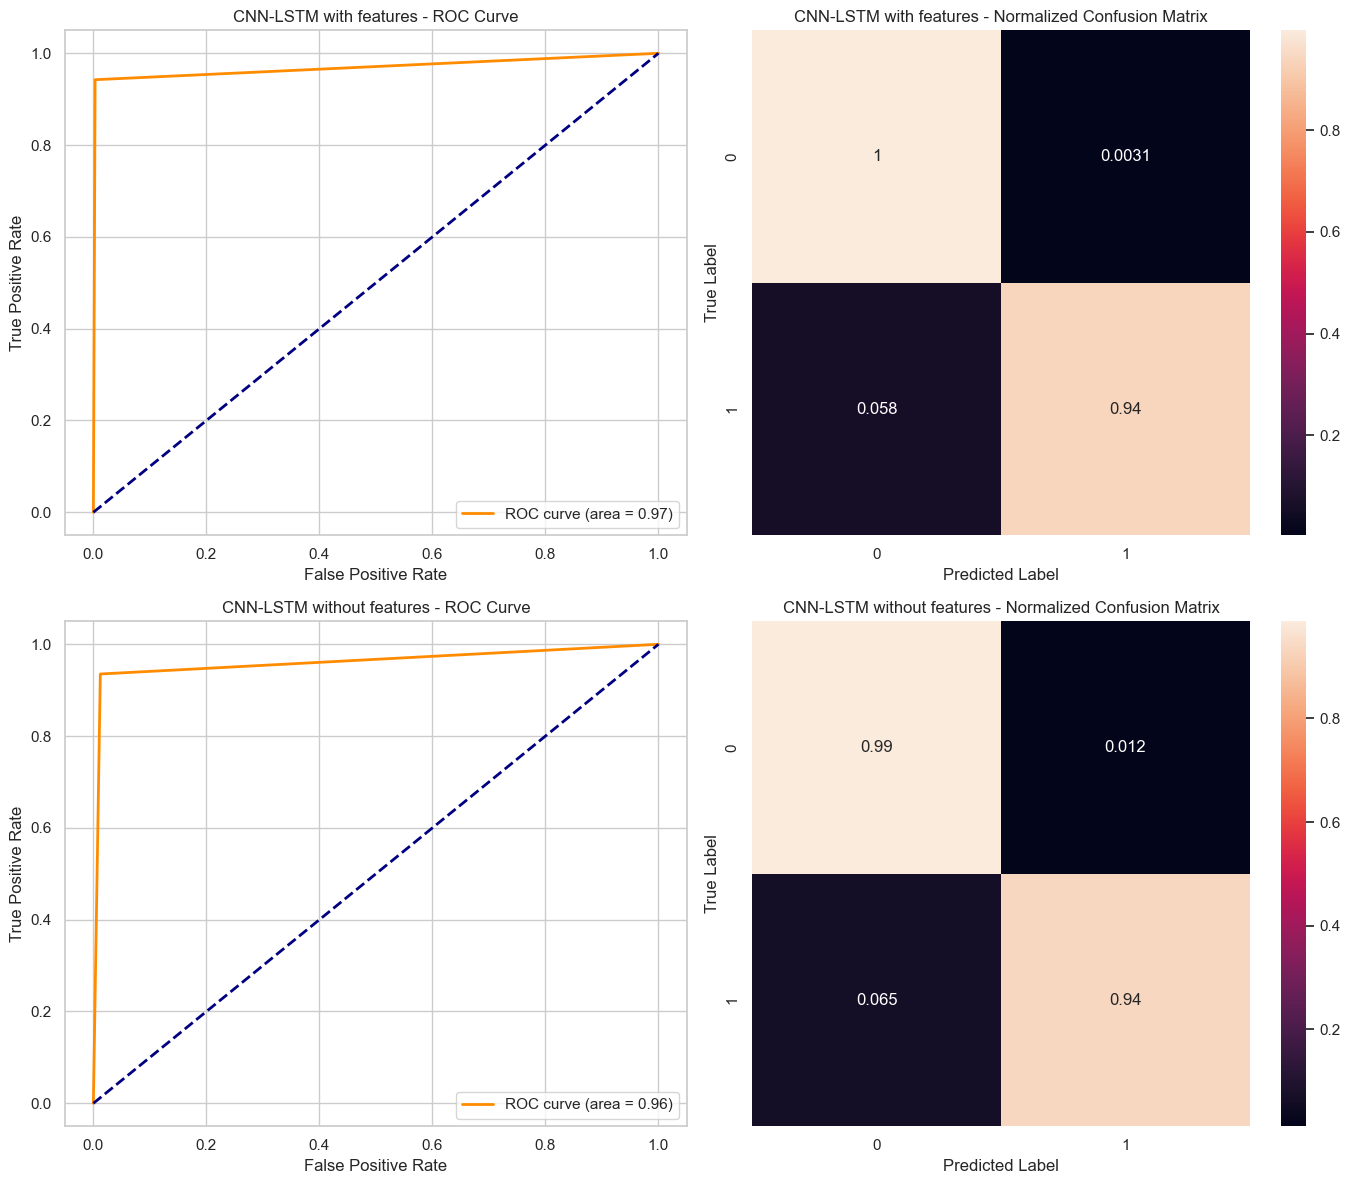

In [177]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Plot for the first model
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN-LSTM with features - ROC Curve')
plt.legend(loc='lower right')

plt.subplot(2, 2, 2)
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN-LSTM with features - Normalized Confusion Matrix')

# Plot for the second model
fpr, tpr, _ = roc_curve(y_test, alt_y_pred)
roc_auc = auc(fpr, tpr)

plt.subplot(2, 2, 3)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN-LSTM without features - ROC Curve')
plt.legend(loc='lower right')

plt.subplot(2, 2, 4)
conf_mat = confusion_matrix(y_test, alt_y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN-LSTM without features - Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

We conducted a paired t-test to check whether the mean difference in accuracy between both models is statistically significant. 
Based on this test, we conclude that our multi-channel model is a more efficient system for SMS spam detection under a significance of p = 0.05 meaning that we reject our initially proposed null hypothesis H<sub>0</sub>.

In [12]:
import scipy.stats as stats

t_statistic, p_value = stats.ttest_rel(history.history["accuracy"], alt_history.history["accuracy"])

# Display the results
print(f"Paired t-test results:")
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")

# Compare p-value to significance level (e.g., alpha = 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in accuracies.")
else:
    print("Fail to reject null hypothesis: No significant difference in accuracies.")


Paired t-test results:
t-statistic: 3.84224321824705
p-value: 0.0015990558405508132
Reject null hypothesis: There is a significant difference in accuracies.


## Discussion

In this notebook, the obtained results prove that a combination of feature engineering techniques and deep learning algorithms in a multi-channel CNN-LSTM can render a promising solution to create efficient systems for SMS spam detection. This was validated by our hypothesis test which we shown under statisical significance that concatenating features in the CNN-LSTM model does improve the model’s overall performance and through a thorough investigation into accuracy metrics such as precision, recall, f1-score, AUC, etc. This indicates that these concatenated features can improve the model's ability to adapt to understand its semantic relationships between words, phrases, or sentences better, better resolve ambiguity and improve representation learning.


Whilst we did show promise in this approach, simpler architectures such as the other paper we took inspiration for their feature engineering used machine learning techniques that boasted a higher accuracy. There were several limitations in building our proposed system. First and foremost, whilst there is a package named Scikeras that combines scikit-learn methods and the Keras paradigm, it still doesn’t readily support multi-channel networks and a problem faced in our project was the inability to use scikit-learn’s GridSearchCV or RandomSearchCV module that we could use for hyperparameter tuning. Moreover, we encountered emojis that were hard to deal with the abundance of emojis existing. We could not discern english-based transliterates such as *Pinyin that were considered incorrectly spelt strings as they were not part of NLTK word bank and their sentiments and general meaning were ambiguously interpreted.

Moving forward, we should focus on different model building paradigms that ensure seamless support for multi-channel networks. This integration should facilitate compatibility with powerful hyperparameter tuning techniques similar to the algorithms in GridSearchCV and RandomSearchCV from scikit-learn. Additionally, resolving the challenge posed by emojis and non-English transliterations, such as Pinyin, demands innovative preprocessing approaches that possibly leverages more advanced NLP techniques such as specialised tokenization methods and emoji embeddings. Furthermore, to counteract the constraint of limited data size, future endeavours should aim for larger and more diverse datasets, potentially leveraging cloud-based or distributed computing resources to accommodate larger data volumes. By mitigating these limitations, the future trajectory aims to bolster the robustness and accuracy of SMS spam detection systems, ensuring their efficacy in real-world applications.


Afterword:
- Pinyins can be found in the WordCloud. For example, liao, lar, etc